## Markdown files load and splitting

To load our documents we will use LangChain DirectoryLoader util

In [7]:
from langchain_community.document_loaders import DirectoryLoader

loader = DirectoryLoader("DSPy_docs", glob="**/*.md")
documents = loader.load()

len(documents)

127

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitted_documents = [] 
chunk_size = 1000
chunk_overlap = 100
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
sections = text_splitter.split_documents(documents)

splitted_documents.extend(sections)

len(splitted_documents)

547

In [12]:
splitted_documents[10]

Document(metadata={'source': 'DSPy_docs/docs/faqs.md'}, page_content='How do I convert my complex prompt into a DSPy pipeline? See the same answer above.\n\nWhat do DSPy optimizers tune? Or, what does compiling actually do? Each optimizer is different, but they all seek to maximize a metric on your program by updating prompts or LM weights. Current DSPy optimizers can inspect your data, simulate traces through your program to generate good/bad examples of each step, propose or refine instructions for each step based on past results, finetune the weights of your LM on self-generated examples, or combine several of these to improve quality or cut cost. We\'d love to merge new optimizers that explore a richer space: most manual steps you currently go through for prompt engineering, "synthetic data" generation, or self-improvement can probably generalized into a DSPy optimizer that acts on arbitrary LM programs.')

## Document embeddings

In [13]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

In [15]:
persist_directory = "embeddings_db"
embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")

### Generate and store embeddings

In [14]:
vectordb = Chroma.from_documents(documents=splitted_documents, embedding=embedding_function, persist_directory=persist_directory)

### Load embeddings db

In [16]:
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding_function)

/tmp/ipykernel_1100835/2620733285.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding_function)


## DSPy RAG

We will review DSPy going through 3 approaches:
- A call to the LM where we have a prompt and a response as a result
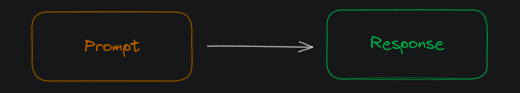

- **Basic RAG**: we are going to add context to that prompt and we will get a response. This context will be extracted from our vectorized database
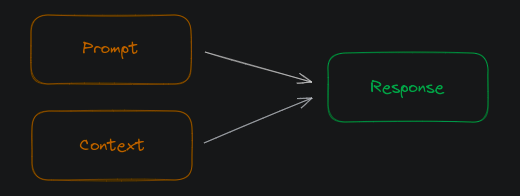

- **RAG with Chain of Thought**: we will ask the model to reason before giving us a response to generate an even better result
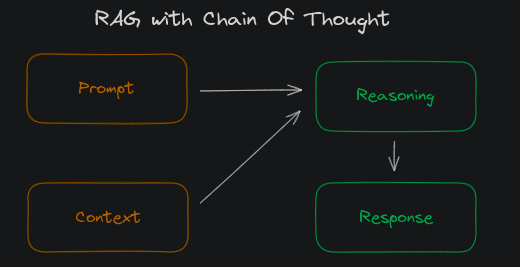


#### Setup

In [25]:
import dspy
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo
from langchain_openai import OpenAI


lm = dspy.LM('openai/gpt-4o-mini')
dspy.configure(lm=lm)


In order to see the improvements of the different methods we will use the same question 

In [26]:
question = "What is a module?"

#### Basic prompt -> response

In [27]:
basic_chat = dspy.Predict("question -> response")

basic_chat(question=question)

Prediction(
    response='A module is a self-contained unit of code that encapsulates a specific functionality or a set of related functions, classes, or variables. In programming, modules help organize code into manageable sections, making it easier to maintain, reuse, and share. They can be imported into other code files, allowing developers to utilize the functionality without having to rewrite it. Modules are commonly used in various programming languages, such as Python, JavaScript, and Ruby, to promote modular programming practices.'
)

### Retrieval Augmented Generation (RAG)

RAG is a technique that enhances Large Language Models (LLMs) by providing them with external knowledge during inference time. Unlike model fine-tuning, this knowledge enhancement is temporary and happens at query time. In our implementation, we'll augment the LLM with content from the DSPy documentation.

RAG consists of two main components:

#### 1. Dense Vector Retrieval

The dense vector retrieval process follows these steps:

1. User question is processed by an embedding model
2. The embedding model converts the question into a dense vector representation
3. This vector queries a vector store containing pre-computed embeddings of the DSPy documentation
4. Using similarity search (typically cosine similarity), the system retrieves the most relevant context pieces

#### 2. In-Context Learning

The in-context learning component structures information for the LLM:

1. A prompt template organizes:
   - System instructions for context utilization
   - The user's original query
   - Retrieved context pieces (referenced as Context 1, 2, etc.)
2. This structured format enables the LLM to:
   - Process the provided context effectively
   - Generate responses based on both its base knowledge and the retrieved information
   - Adapt to specific queries without parameter updates

The combination of these components allows RAG to enhance LLM responses with current, relevant information while maintaining the model's core capabilities.

#### Context Retrieval

In [28]:
retriever = vectordb.as_retriever()

def retrieve(inputs):
  return [doc.page_content for doc in retriever.invoke(inputs["question"])]

#### Basic RAG

In [29]:
# Define our RAG module
class RAG(dspy.Module):
    def __init__(self):
        self.response = dspy.Predict("context, question -> response")
        
    def forward(self, question):
        context = retrieve({"question": question})
        return self.response(context=context, question=question)

In [ ]:
rag = RAG()

rag(question=question)

In [ ]:
dspy.inspect_history()

#### RAG with CoT

In [41]:
class COT_RAG(dspy.Module):
    def __init__(self):
        self.respond = dspy.ChainOfThought("context, question -> response")
        
    def forward(self, question):
        context = retrieve({"question": question})
        return self.respond(context=context, question=question) 

In [42]:
cot_rag = COT_RAG()

cot_rag(question=question)

Prediction(
    reasoning='A module in the context of DSPy is a building block for programs that utilize language models (LMs). It abstracts prompting techniques and is designed to handle various input signatures. Each module has learnable parameters and can be invoked to process inputs and return outputs. Modules can be composed into larger programs, similar to how neural network modules work in PyTorch. The fundamental module is dspy.Predict, which serves as the basis for other modules, allowing for the declaration of signatures, invocation with input arguments, and extraction of output fields.',
    response='A module in DSPy is a fundamental building block for programs that use language models. It abstracts prompting techniques, has learnable parameters, and can be invoked to process inputs and return outputs. Modules can be composed into larger programs, and the basic module is dspy.Predict, which allows for defining behavior through signatures and handling input and output effect

In [ ]:
dspy.inspect_history()

## Evaluation

To evaluate our DSPy RAG system's effectiveness, we need two key components:

#### Test Inputs 

- We should gather a representative set of queries that users might ask about the DSPy documentation.

#### Evaluation Metrics 

- Gold-Standard Metrics: These require reference answers from the DSPy documentation to verify factual accuracy and completeness.

We will continue with Gold-Standard Metrics with a very small dataset of 20 QA for showcase purposes. In a real use-case we would need a larger dataset with curated data.

##### Test inputs

In [47]:
import json

# Load training data

with open("dspy_qa_examples.json") as f:
    data = json.load(f)
    
len(data)

20

##### Examples in DSPy

Given a simple dict like this, let's create a list of dspy.Examples, which is the datatype that carries training (or test) datapoints in DSPy.

When you build a dspy.Example, you should generally specify .with_inputs("field1", "field2", ...) to indicate which fields are inputs. The other fields are treated as labels or metadata.

In [48]:
data = [dspy.Example(**d).with_inputs('question') for d in data]

# Let's pick an `example` here from the data.
example = data[1]
example

Example({'question': 'How do you implement metric evaluation in DSPy and what are the key steps?', 'response': "Implementing metric evaluation in DSPy involves three key steps: 1) Collect an initial development set - gathering at least 20 input examples (though 200 is better) of your task, either from existing datasets or by creating your own. You only need inputs and final outputs, not intermediate steps. 2) Define your DSPy metric - create a function that takes examples from your data and system outputs and returns a score. For simple tasks this could be accuracy, while for long-form outputs it might be a smaller DSPy program checking multiple properties. 3) Run development evaluations - test your pipeline designs against the metric to understand tradeoffs and establish a baseline for improvements. The metric itself can be optimized if it's a DSPy program by collecting examples and optimizing against a simpler scoring system."}) (input_keys={'question'})

Let's divide the data into:

Training (and with it Validation) set:

- These are the splits you typically give to DSPy optimizers.
- Optimizers typically learn directly from the training examples and check their progress using the validation examples.
- It's good to have 30--300 examples for training and validation each.
- For prompt optimizers in particular, it's often better to pass more validation than training.
- We'll use 20 in total. MIPROv2 will split them into 20% training and 80% validation if you don't pass a valset.

Development and Test sets: The rest, typically on the order of 30-1000, can be used for:

- development (i.e., you can inspect them as you iterate on your system) and
- testing (final held-out evaluation).

In [49]:
import random

random.Random(0).shuffle(data)
trainset, devset, testset = data[:4], data[5:10], data[10:20]

len(trainset), len(devset), len(testset)

(4, 5, 10)

##### Evaluating Question-Answering Performance

For our long-form question-answering system, we need to measure two things:

How well does our system cover the key facts from the reference answer?
How well does it avoid including incorrect or unsupported information?

DSPy's SemanticF1 metric handles both aspects, using our language model to compare the semantic similarity between generated and reference answers

The Semantic F1 score balances both:

- Recall: Measures how many key points from the reference answer are captured
- Precision: Measures how much of the generated answer is supported by the reference

In [50]:
from dspy.evaluate import SemanticF1

# Instantiate the metric.
metric = SemanticF1(decompositional=True)

In [52]:
# Produce a prediction from our basic rag module, using the `example` above as input.
pred = cot_rag(**example.inputs())

# Compute the metric score for the prediction.
score = metric(example, pred)

print(f"Question: \n {example.question}\n")
print(f"Gold Response: \n {example.response}\n")
print(f"Predicted Response: \n {pred.response}\n")
print(f"Semantic F1 Score: {score:.2f}")

Question: 
 How do you implement metric evaluation in DSPy and what are the key steps?

Gold Response: 
 Implementing metric evaluation in DSPy involves three key steps: 1) Collect an initial development set - gathering at least 20 input examples (though 200 is better) of your task, either from existing datasets or by creating your own. You only need inputs and final outputs, not intermediate steps. 2) Define your DSPy metric - create a function that takes examples from your data and system outputs and returns a score. For simple tasks this could be accuracy, while for long-form outputs it might be a smaller DSPy program checking multiple properties. 3) Run development evaluations - test your pipeline designs against the metric to understand tradeoffs and establish a baseline for improvements. The metric itself can be optimized if it's a DSPy program by collecting examples and optimizing against a simpler scoring system.

Predicted Response: 
 To implement metric evaluation in DSPy, fo

In [53]:
dspy.inspect_history()





[2025-01-11T12:06:27.170449]

System message:

Your input fields are:
1. `question` (str)
2. `ground_truth` (str)
3. `system_response` (str)

Your output fields are:
1. `reasoning` (str)
2. `ground_truth_key_ideas` (str): enumeration of key ideas in the ground truth
3. `system_response_key_ideas` (str): enumeration of key ideas in the system response
4. `discussion` (str): discussion of the overlap between ground truth and system response
5. `recall` (float): fraction (out of 1.0) of ground truth covered by the system response
6. `precision` (float): fraction (out of 1.0) of system response covered by the ground truth

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## question ## ]]
{question}

[[ ## ground_truth ## ]]
{ground_truth}

[[ ## system_response ## ]]
{system_response}

[[ ## reasoning ## ]]
{reasoning}

[[ ## ground_truth_key_ideas ## ]]
{ground_truth_key_ideas}

[[ ## system_response_key_ideas ## ]]
{system_response

## Optimization

Off the shelf, our COT RAG module scores 57%. What are our options to make it stronger? One of the various choices DSPy offers is optimizing the prompts in our pipeline.

We will use DSPy's MIPRO (v2) optimizer

One good thing about DSPy is that we can use different model for each task. In our case we will use DeepSeek to optimize our RAG system since it's cheaper to use.

In [54]:
import os

optimizer_lm = dspy.OpenAI(
    model="deepseek-chat", 
    model_type="chat", 
    api_key=os.environ["DEEPSEEK_API_KEY"], 
    base_url="https://api.deepseek.com"
)

optimizer_lm.request(prompt="What model are you ").get("choices")[0].get("message").get("content")

'I am DeepSeek-V3, an AI assistant created exclusively by the Chinese Company DeepSeek. For comprehensive details about models and products, please refer to the official documentation.'

In [57]:
tp = dspy.MIPROv2(metric=metric, auto="medium", num_threads=8, prompt_model=optimizer_lm)

optimized_rag = tp.compile(COT_RAG(), trainset=trainset,
                           max_bootstrapped_demos=2, max_labeled_demos=2,
                           requires_permission_to_run=False)

2025/01/11 12:14:15 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING MEDIUM AUTO RUN SETTINGS:
num_trials: 25
minibatch: False
num_candidates: 19
valset size: 3

2025/01/11 12:14:15 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/01/11 12:14:15 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/01/11 12:14:15 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=19 sets of demonstrations...


Bootstrapping set 1/19
Bootstrapping set 2/19
Bootstrapping set 3/19


100%|██████████| 1/1 [00:11<00:00, 11.45s/it]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 4/19


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 5/19


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 6/19


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 7/19


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 8/19


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 9/19


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 10/19


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 11/19


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 12/19


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 13/19


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 14/19


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 15/19


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 16/19


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 17/19


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 18/19


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Bootstrapping set 19/19


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]
2025/01/11 12:14:35 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/01/11 12:14:35 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/01/11 12:14:35 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing instructions...



Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.


2025/01/11 12:15:10 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/01/11 12:15:10 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Given the fields `context`, `question`, produce the fields `response`.

2025/01/11 12:15:10 INFO dspy.teleprompt.mipro_optimizer_v2: 1: Given a `context` and a `question`, generate a detailed step-by-step reasoning process (`reasoning`) that logically connects the context to the answer. Use the reasoning to produce a clear and accurate `response` that directly addresses the question. Ensure the reasoning is structured, concise, and demonstrates how the context informs the response. If the context is insufficient to answer the question, indicate this in the reasoning and provide a response that acknowledges the lack of information."  

This instruction emphasizes the importance of structured reasoning and ensures the LM explicitly connects the context to the response, addressing potential gaps in information. It also encoura

Average Metric: 1.11 / 3 (36.9%): 100%|██████████| 3/3 [00:17<00:00,  5.88s/it]

2025/01/11 12:15:27 INFO dspy.evaluate.evaluate: Average Metric: 1.1079545454545454 / 3 (36.9%)
2025/01/11 12:15:27 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 36.93

2025/01/11 12:15:27 INFO dspy.teleprompt.mipro_optimizer_v2: ==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
2025/01/11 12:15:27 INFO dspy.teleprompt.mipro_optimizer_v2: We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

/home/jarancibia/Documents/Projects/dspy-rag/venv/lib/python3.10/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/01/11 12:15:27 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 1 / 25 =====



Average Metric: 1.44 / 3 (48.0%): 100%|██████████| 3/3 [00:17<00:00,  5.77s/it]

2025/01/11 12:15:45 INFO dspy.evaluate.evaluate: Average Metric: 1.4408602150537635 / 3 (48.0%)
2025/01/11 12:15:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 48.03
2025/01/11 12:15:45 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.03 with parameters ['Predictor 0: Instruction 12', 'Predictor 0: Few-Shot Set 7'].
2025/01/11 12:15:45 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03]
2025/01/11 12:15:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 48.03
2025/01/11 12:15:45 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/01/11 12:15:45 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 2 / 25 =====



Average Metric: 1.44 / 3 (48.0%): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

2025/01/11 12:15:46 INFO dspy.evaluate.evaluate: Average Metric: 1.4408602150537635 / 3 (48.0%)
2025/01/11 12:15:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.03 with parameters ['Predictor 0: Instruction 10', 'Predictor 0: Few-Shot Set 7'].
2025/01/11 12:15:46 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03]
2025/01/11 12:15:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 48.03
2025/01/11 12:15:46 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/01/11 12:15:46 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 3 / 25 =====



Average Metric: 1.76 / 3 (58.7%): 100%|██████████| 3/3 [00:20<00:00,  6.84s/it]

2025/01/11 12:16:06 INFO dspy.evaluate.evaluate: Average Metric: 1.7608391608391607 / 3 (58.7%)
2025/01/11 12:16:06 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 58.69
2025/01/11 12:16:06 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 58.69 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 18'].
2025/01/11 12:16:06 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69]
2025/01/11 12:16:06 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 58.69
2025/01/11 12:16:06 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/01/11 12:16:06 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 4 / 25 =====



Average Metric: 1.71 / 3 (57.0%): 100%|██████████| 3/3 [00:17<00:00,  5.81s/it]

2025/01/11 12:16:24 INFO dspy.evaluate.evaluate: Average Metric: 1.7087646652864044 / 3 (57.0%)
2025/01/11 12:16:24 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 56.96 with parameters ['Predictor 0: Instruction 15', 'Predictor 0: Few-Shot Set 2'].
2025/01/11 12:16:24 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96]
2025/01/11 12:16:24 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 58.69
2025/01/11 12:16:24 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/01/11 12:16:24 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 5 / 25 =====



Average Metric: 1.71 / 3 (57.0%): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

2025/01/11 12:16:25 INFO dspy.evaluate.evaluate: Average Metric: 1.7087646652864044 / 3 (57.0%)
2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 56.96 with parameters ['Predictor 0: Instruction 8', 'Predictor 0: Few-Shot Set 18'].
2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96]
2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 58.69
2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 6 / 25 =====



Average Metric: 1.76 / 3 (58.7%): 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

2025/01/11 12:16:25 INFO dspy.evaluate.evaluate: Average Metric: 1.7608391608391607 / 3 (58.7%)
2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 58.69 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 1'].
2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69]
2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 58.69
2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/01/11 12:16:25 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 25 =====



Average Metric: 1.76 / 3 (58.7%): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

2025/01/11 12:16:26 INFO dspy.evaluate.evaluate: Average Metric: 1.7608391608391607 / 3 (58.7%)
2025/01/11 12:16:26 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 58.69 with parameters ['Predictor 0: Instruction 7', 'Predictor 0: Few-Shot Set 12'].
2025/01/11 12:16:26 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69]
2025/01/11 12:16:26 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 58.69
2025/01/11 12:16:26 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/01/11 12:16:26 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 8 / 25 =====



Average Metric: 1.76 / 3 (58.7%): 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

2025/01/11 12:16:27 INFO dspy.evaluate.evaluate: Average Metric: 1.7608391608391607 / 3 (58.7%)
2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 58.69 with parameters ['Predictor 0: Instruction 11', 'Predictor 0: Few-Shot Set 13'].
2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69]
2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 58.69
2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 9 / 25 =====



Average Metric: 1.76 / 3 (58.7%): 100%|██████████| 3/3 [00:00<00:00,  9.32it/s]

2025/01/11 12:16:27 INFO dspy.evaluate.evaluate: Average Metric: 1.7608391608391607 / 3 (58.7%)
2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 58.69 with parameters ['Predictor 0: Instruction 5', 'Predictor 0: Few-Shot Set 4'].
2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69]
2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 58.69
2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: ========================


2025/01/11 12:16:27 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 10 / 25 =====



Average Metric: 1.97 / 3 (65.6%): 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]

2025/01/11 12:16:44 INFO dspy.evaluate.evaluate: Average Metric: 1.9683035714285713 / 3 (65.6%)
2025/01/11 12:16:44 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 65.61
2025/01/11 12:16:44 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.61 with parameters ['Predictor 0: Instruction 14', 'Predictor 0: Few-Shot Set 1'].
2025/01/11 12:16:44 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61]
2025/01/11 12:16:44 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 65.61
2025/01/11 12:16:44 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:16:44 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 11 / 25 =====



Average Metric: 1.76 / 3 (58.7%): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

2025/01/11 12:16:45 INFO dspy.evaluate.evaluate: Average Metric: 1.7608391608391607 / 3 (58.7%)
2025/01/11 12:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 58.69 with parameters ['Predictor 0: Instruction 13', 'Predictor 0: Few-Shot Set 1'].
2025/01/11 12:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69]
2025/01/11 12:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 65.61
2025/01/11 12:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:16:45 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 12 / 25 =====



Average Metric: 1.97 / 3 (65.6%): 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

2025/01/11 12:16:46 INFO dspy.evaluate.evaluate: Average Metric: 1.9683035714285713 / 3 (65.6%)
2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.61 with parameters ['Predictor 0: Instruction 14', 'Predictor 0: Few-Shot Set 1'].
2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61]
2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 65.61
2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 25 =====



Average Metric: 1.97 / 3 (65.6%): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

2025/01/11 12:16:46 INFO dspy.evaluate.evaluate: Average Metric: 1.9683035714285713 / 3 (65.6%)
2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.61 with parameters ['Predictor 0: Instruction 14', 'Predictor 0: Few-Shot Set 1'].
2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61]
2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 65.61
2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:16:46 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 14 / 25 =====



Average Metric: 1.99 / 3 (66.2%): 100%|██████████| 3/3 [00:15<00:00,  5.31s/it]

2025/01/11 12:17:02 INFO dspy.evaluate.evaluate: Average Metric: 1.9855464938713676 / 3 (66.2%)
2025/01/11 12:17:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 66.18
2025/01/11 12:17:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 66.18 with parameters ['Predictor 0: Instruction 14', 'Predictor 0: Few-Shot Set 0'].
2025/01/11 12:17:02 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18]
2025/01/11 12:17:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 66.18
2025/01/11 12:17:02 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:17:02 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 15 / 25 =====



Average Metric: 1.97 / 3 (65.6%): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

2025/01/11 12:17:03 INFO dspy.evaluate.evaluate: Average Metric: 1.9683035714285713 / 3 (65.6%)
2025/01/11 12:17:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.61 with parameters ['Predictor 0: Instruction 14', 'Predictor 0: Few-Shot Set 10'].
2025/01/11 12:17:03 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61]
2025/01/11 12:17:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 66.18
2025/01/11 12:17:03 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:17:03 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 16 / 25 =====



Average Metric: 1.63 / 3 (54.2%): 100%|██████████| 3/3 [00:17<00:00,  5.87s/it]

2025/01/11 12:17:21 INFO dspy.evaluate.evaluate: Average Metric: 1.62535739151672 / 3 (54.2%)
2025/01/11 12:17:21 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 54.18 with parameters ['Predictor 0: Instruction 4', 'Predictor 0: Few-Shot Set 0'].
2025/01/11 12:17:21 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18]
2025/01/11 12:17:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 66.18
2025/01/11 12:17:21 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:17:21 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 17 / 25 =====



Average Metric: 1.99 / 3 (66.2%): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

2025/01/11 12:17:22 INFO dspy.evaluate.evaluate: Average Metric: 1.9855464938713676 / 3 (66.2%)
2025/01/11 12:17:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 66.18 with parameters ['Predictor 0: Instruction 14', 'Predictor 0: Few-Shot Set 0'].
2025/01/11 12:17:22 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18, 66.18]
2025/01/11 12:17:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 66.18
2025/01/11 12:17:22 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:17:22 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 18 / 25 =====



Average Metric: 1.99 / 3 (66.2%): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

2025/01/11 12:17:23 INFO dspy.evaluate.evaluate: Average Metric: 1.9855464938713676 / 3 (66.2%)
2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 66.18 with parameters ['Predictor 0: Instruction 14', 'Predictor 0: Few-Shot Set 0'].


2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18, 66.18, 66.18]
2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 66.18
2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 25 =====


Average Metric: 1.99 / 3 (66.2%): 100%|██████████| 3/3 [00:00<00:00,  7.31it/s]

2025/01/11 12:17:23 INFO dspy.evaluate.evaluate: Average Metric: 1.9855464938713676 / 3 (66.2%)
2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 66.18 with parameters ['Predictor 0: Instruction 18', 'Predictor 0: Few-Shot Set 0'].
2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18, 66.18, 66.18, 66.18]
2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 66.18
2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:17:23 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 20 / 25 =====



Average Metric: 1.46 / 3 (48.5%): 100%|██████████| 3/3 [00:14<00:00,  4.86s/it]

2025/01/11 12:17:38 INFO dspy.evaluate.evaluate: Average Metric: 1.455743879472693 / 3 (48.5%)
2025/01/11 12:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.52 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 6'].
2025/01/11 12:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18, 66.18, 66.18, 66.18, 48.52]
2025/01/11 12:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 66.18
2025/01/11 12:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:17:38 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 21 / 25 =====



Average Metric: 1.74 / 3 (57.9%): 100%|██████████| 3/3 [00:17<00:00,  5.97s/it]

2025/01/11 12:17:55 INFO dspy.evaluate.evaluate: Average Metric: 1.7380952380952381 / 3 (57.9%)
2025/01/11 12:17:55 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 57.94 with parameters ['Predictor 0: Instruction 16', 'Predictor 0: Few-Shot Set 15'].
2025/01/11 12:17:55 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18, 66.18, 66.18, 66.18, 48.52, 57.94]
2025/01/11 12:17:55 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 66.18
2025/01/11 12:17:55 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:17:55 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 22 / 25 =====



Average Metric: 2.21 / 3 (73.6%): 100%|██████████| 3/3 [00:25<00:00,  8.53s/it]

2025/01/11 12:18:21 INFO dspy.evaluate.evaluate: Average Metric: 2.2074992650399548 / 3 (73.6%)
2025/01/11 12:18:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far! Score: 73.58
2025/01/11 12:18:21 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 73.58 with parameters ['Predictor 0: Instruction 11', 'Predictor 0: Few-Shot Set 0'].
2025/01/11 12:18:21 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18, 66.18, 66.18, 66.18, 48.52, 57.94, 73.58]
2025/01/11 12:18:21 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 73.58
2025/01/11 12:18:21 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:18:21 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 23 / 25 =====



Average Metric: 1.97 / 3 (65.6%): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

2025/01/11 12:18:22 INFO dspy.evaluate.evaluate: Average Metric: 1.9683035714285713 / 3 (65.6%)
2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 65.61 with parameters ['Predictor 0: Instruction 6', 'Predictor 0: Few-Shot Set 17'].
2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18, 66.18, 66.18, 66.18, 48.52, 57.94, 73.58, 65.61]
2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 73.58
2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 24 / 25 =====



Average Metric: 2.21 / 3 (73.6%): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

2025/01/11 12:18:22 INFO dspy.evaluate.evaluate: Average Metric: 2.2074992650399548 / 3 (73.6%)
2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 73.58 with parameters ['Predictor 0: Instruction 11', 'Predictor 0: Few-Shot Set 0'].
2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18, 66.18, 66.18, 66.18, 48.52, 57.94, 73.58, 65.61, 73.58]
2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 73.58
2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:18:22 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 25 / 25 =====



Average Metric: 2.21 / 3 (73.6%): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

2025/01/11 12:18:23 INFO dspy.evaluate.evaluate: Average Metric: 2.2074992650399548 / 3 (73.6%)
2025/01/11 12:18:23 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 73.58 with parameters ['Predictor 0: Instruction 11', 'Predictor 0: Few-Shot Set 0'].
2025/01/11 12:18:23 INFO dspy.teleprompt.mipro_optimizer_v2: Scores so far: [36.93, 48.03, 48.03, 58.69, 56.96, 56.96, 58.69, 58.69, 58.69, 58.69, 65.61, 58.69, 65.61, 65.61, 66.18, 65.61, 54.18, 66.18, 66.18, 66.18, 48.52, 57.94, 73.58, 65.61, 73.58, 73.58]
2025/01/11 12:18:23 INFO dspy.teleprompt.mipro_optimizer_v2: Best score so far: 73.58
2025/01/11 12:18:23 INFO dspy.teleprompt.mipro_optimizer_v2: =========================


2025/01/11 12:18:23 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 73.58!


In [58]:
# Produce a prediction from our basic rag module, using the `example` above as input.
pred = optimized_rag(**example.inputs())

# Compute the metric score for the prediction.
score = metric(example, pred)

print(f"Question: \n {example.question}\n")
print(f"Gold Response: \n {example.response}\n")
print(f"Predicted Response: \n {pred.response}\n")
print(f"Semantic F1 Score: {score:.2f}")

Question: 
 How do you implement metric evaluation in DSPy and what are the key steps?

Gold Response: 
 Implementing metric evaluation in DSPy involves three key steps: 1) Collect an initial development set - gathering at least 20 input examples (though 200 is better) of your task, either from existing datasets or by creating your own. You only need inputs and final outputs, not intermediate steps. 2) Define your DSPy metric - create a function that takes examples from your data and system outputs and returns a score. For simple tasks this could be accuracy, while for long-form outputs it might be a smaller DSPy program checking multiple properties. 3) Run development evaluations - test your pipeline designs against the metric to understand tradeoffs and establish a baseline for improvements. The metric itself can be optimized if it's a DSPy program by collecting examples and optimizing against a simpler scoring system.

Predicted Response: 
 To implement metric evaluation in DSPy, fo